# Предварительный код

In [1]:
import numpy as np
import pandas as pd
import torch
import random
import os
import lightning as L

from torchmetrics.classification import BinaryAccuracy

In [2]:
# basic random seed
def seed_basic(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)


# torch random seed
def seed_torch(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# basic + torch + lightning
def seed_everything(seed=42):
    seed_basic(seed)
    seed_torch(seed)
    L.seed_everything(seed)


seed_everything()

Seed set to 42


In [3]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings("ignore")

def create_trainer(name, max_epochs = 10):
    checkpoint_callback = ModelCheckpoint(
    dirpath=f'checkpoints/{name}',
    save_last=False,
    every_n_epochs=1,
    save_top_k=1,
    monitor="loss/val",
    filename=name,
    mode="min",
    )

    torch.set_float32_matmul_precision('medium')
    trainer = L.Trainer(
        max_epochs=max_epochs,
        callbacks=[checkpoint_callback],
        num_sanity_val_steps=1,
        log_every_n_steps=5,
        logger=L.pytorch.loggers.CSVLogger(save_dir=f"logs/", name = name),
    )
    return trainer

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Загрузка данных и модели

In [5]:
from datasets import load_dataset

dataset_train = load_dataset("glue", "mrpc", split="train")
dataset_val = load_dataset("glue", "mrpc", split="validation")
dataset_test = load_dataset("glue", "mrpc", split="test")

In [6]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

base_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def encode(examples):
    return tokenizer(examples["sentence1"], examples["sentence2"], truncation=True, padding="max_length")

dataset_train = dataset_train.map(encode, batched=True)
dataset_train = dataset_train.map(lambda examples: {"labels": examples["label"]}, batched=True)
dataset_val = dataset_val.map(encode, batched=True)
dataset_val = dataset_val.map(lambda examples: {"labels": examples["label"]}, batched=True)
dataset_test = dataset_test.map(encode, batched=True)
dataset_test = dataset_test.map(lambda examples: {"labels": examples["label"]}, batched=True)

In [8]:
import torch

dataset_train.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle = True)
dataset_val.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])
val_dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=32, shuffle = False)
dataset_test.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])
test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle = False)

# Тренировка

## LoRA

In [9]:
from peft import LoraConfig, TaskType

peft_config = LoraConfig(task_type = 'text-classification', inference_mode=False, r=10, lora_alpha=32, lora_dropout=0.1)

In [10]:
from peft import get_peft_model

model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

trainable params: 368,640 || all params: 109,852,418 || trainable%: 0.3356


### Кастомный Trainer

In [19]:
class LModel(L.LightningModule):

    def __init__(
            self, model, lr=2e-4,
        ):
        super().__init__()
        self.model = model
        self.train_acc = BinaryAccuracy()
        self.valid_acc = BinaryAccuracy()
        self.test_acc = BinaryAccuracy()
        self.lr = lr
        self.automatic_optimization = True

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr = self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        y = batch['labels']
        out = self.model.forward(**batch)
        logits = out.logits
        loss = out.loss
        preds = torch.nn.functional.softmax(logits, dim = 1)[:,1]
        self.train_acc.update((preds.detach()), y.detach())
        self.log("loss/train", loss.detach().item(), prog_bar=True)
        return loss
        
    def on_train_epoch_end(self):
        self.log("Acc/train", self.train_acc.compute(), prog_bar=True)
        self.train_acc.reset()
        
    def validation_step(self, batch, batch_idx):
        y = batch['labels']
        out = self.model.forward(**batch)
        logits = out.logits
        loss = out.loss
        preds = torch.nn.functional.softmax(logits, dim = 1)[:,1]
        self.valid_acc.update((preds.detach()), y.detach())
        self.log("loss/val", loss.detach().item())
        
    def on_validation_epoch_end(self):
        self.log("Acc/val", self.valid_acc.compute(), prog_bar=True)
        self.valid_acc.reset()
        
    def test_step(self, batch, batch_idx):
        y = batch['labels']
        out = self.model.forward(**batch)
        logits = out.logits
        preds = torch.nn.functional.softmax(logits, dim = 1)[:,1]
        self.test_acc.update((preds.detach()), y.detach())
        
    def on_test_epoch_end(self):
        self.log("Acc/test", self.test_acc.compute(), prog_bar=True)
        self.test_acc.reset()

In [89]:
pl_model = LModel(base_model)
trainer = create_trainer("BERT", max_epochs = 15)
trainer.test(pl_model, dataloaders = test_dataloader);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Acc/test          │    0.33507245779037476    │
└───────────────────────────┴───────────────────────────┘

In [13]:
pl_model = LModel(model)
trainer = create_trainer("BERT_lora", max_epochs = 15)
trainer.test(pl_model, dataloaders = test_dataloader);

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Acc/test          │    0.6649275422096252     │
└───────────────────────────┴───────────────────────────┘

In [14]:
trainer.fit(
    model=pl_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | PeftModel      | 109 M  | train
1 | train_acc | BinaryAccuracy | 0      | train
2 | valid_acc | BinaryAccuracy | 0      | train
3 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
368 K     Trainable params
109 M     Non-trainable params
109 M     Total params
439.410   Total estimated model params size (MB)
245       Modules in train mode
231       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [15]:
trainer.test(pl_model, dataloaders = test_dataloader);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Acc/test          │    0.8208695650100708     │
└───────────────────────────┴───────────────────────────┘

## AdaLoRA

In [20]:
from peft import AdaLoraConfig, TaskType
from peft import get_peft_model

max_epochs = 15
peft_config = AdaLoraConfig(task_type = 'text-classification', inference_mode=False, r=10, lora_alpha=32, lora_dropout=0.1, total_step = max_epochs*len(train_dataloader))
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 442,656 || all params: 109,926,458 || trainable%: 0.4027


In [21]:
class LModel(L.LightningModule):

    def __init__(
            self, model, lr=2e-4,
        ):
        super().__init__()
        self.model = model
        self.train_acc = BinaryAccuracy()
        self.valid_acc = BinaryAccuracy()
        self.test_acc = BinaryAccuracy()
        self.lr = lr
        self.automatic_optimization = False
        self.i_step = 0

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr = self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        y = batch['labels']
        out = self.model.forward(**batch)
        logits = out.logits
        
        #---Manual optimization block---
        opt = self.optimizers() 
        opt.zero_grad()
        loss = out.loss
        self.manual_backward(loss)
        self.model.base_model.update_and_allocate(self.i_step) #Step AdaLoRA
        opt.step()
        
        preds = torch.nn.functional.softmax(logits, dim = 1)[:,1]
        self.train_acc.update((preds.detach()), y.detach())
        self.log("loss/train", loss.detach().item(), prog_bar=True)
        self.i_step += 1
        return loss
        
    def on_train_epoch_end(self):
        self.log("Acc/train", self.train_acc.compute(), prog_bar=True)
        self.train_acc.reset()
        
    def validation_step(self, batch, batch_idx):
        y = batch['labels']
        out = self.model.forward(**batch)
        logits = out.logits
        loss = out.loss
        preds = torch.nn.functional.softmax(logits, dim = 1)[:,1]
        self.valid_acc.update((preds.detach()), y.detach())
        self.log("loss/val", loss.detach().item())
        
    def on_validation_epoch_end(self):
        self.log("Acc/val", self.valid_acc.compute(), prog_bar=True)
        self.valid_acc.reset()
        
    def test_step(self, batch, batch_idx):
        y = batch['labels']
        out = self.model.forward(**batch)
        logits = out.logits
        preds = torch.nn.functional.softmax(logits, dim = 1)[:,1]
        self.test_acc.update((preds.detach()), y.detach())
        
    def on_test_epoch_end(self):
        self.log("Acc/test", self.test_acc.compute(), prog_bar=True)
        self.test_acc.reset()

In [22]:
pl_model = LModel(model)
trainer = create_trainer("BERT_adalora", max_epochs = max_epochs)
trainer.test(pl_model, dataloaders = test_dataloader);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Acc/test          │    0.6649275422096252     │
└───────────────────────────┴───────────────────────────┘

In [23]:
trainer.fit(
    model=pl_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | PeftModel      | 109 M  | train
1 | train_acc | BinaryAccuracy | 0      | train
2 | valid_acc | BinaryAccuracy | 0      | train
3 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
442 K     Trainable params
109 M     Non-trainable params
109 M     Total params
439.706   Total estimated model params size (MB)
245       Modules in train mode
231       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [24]:
trainer.test(pl_model, dataloaders = test_dataloader);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Acc/test          │    0.8226087093353271     │
└───────────────────────────┴───────────────────────────┘

## RoseLoRA

In [9]:
from src.rose_lora import SparseSVDLinear, RoseLoraModel
from peft import LoraConfig, TaskType

max_epochs = 20
peft_config = LoraConfig(task_type = 'text-classification', inference_mode=False, r=10, lora_alpha=32, lora_dropout=0.1)
base_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

adaLora_wrapper = RoseLoraModel(base_model, peft_config, adapter_name="default", total_step = max_epochs*len(train_dataloader), sparsity=0.1)
roseLora_model = adaLora_wrapper


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
class LModelRoseLora(L.LightningModule):

    def __init__(
            self, model, lr=2e-4,
        ):
        super().__init__()
        self.model = model
        self.train_acc = BinaryAccuracy()
        self.valid_acc = BinaryAccuracy()
        self.test_acc = BinaryAccuracy()
        self.lr = lr
        self.automatic_optimization = False
        self.i_step = 0

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr = self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        y = batch['labels']
        out = self.model.forward(**batch)
        logits = out.logits
        
        #---Manual optimization block---
        opt = self.optimizers() 
        opt.zero_grad()
        loss = out.loss
        self.manual_backward(loss)
        opt.step()
        self.model.update_and_allocate(self.i_step) #Step RoseLoRA
        
        preds = torch.nn.functional.softmax(logits, dim = 1)[:,1]
        self.train_acc.update((preds.detach()), y.detach())
        self.log("loss/train", loss.detach().item(), prog_bar=True)
        self.i_step += 1
        return loss
        
    def on_train_epoch_end(self):
        self.log("Acc/train", self.train_acc.compute(), prog_bar=True)
        self.train_acc.reset()
        
    def validation_step(self, batch, batch_idx):
        y = batch['labels']
        out = self.model.forward(**batch)
        logits = out.logits
        loss = out.loss
        preds = torch.nn.functional.softmax(logits, dim = 1)[:,1]
        self.valid_acc.update((preds.detach()), y.detach())
        self.log("loss/val", loss.detach().item())
        
    def on_validation_epoch_end(self):
        self.log("Acc/val", self.valid_acc.compute(), prog_bar=True)
        self.valid_acc.reset()
        
    def test_step(self, batch, batch_idx):
        y = batch['labels']
        out = self.model.forward(**batch)
        logits = out.logits
        preds = torch.nn.functional.softmax(logits, dim = 1)[:,1]
        self.test_acc.update((preds.detach()), y.detach())
        
    def on_test_epoch_end(self):
        self.log("Acc/test", self.test_acc.compute(), prog_bar=True)
        self.test_acc.reset()

In [11]:
pl_roseLora_model = LModelRoseLora(roseLora_model)
trainer = create_trainer("BERT_roselora", max_epochs = max_epochs)
trainer.test(pl_roseLora_model, dataloaders = test_dataloader);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Acc/test          │    0.6649275422096252     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | model     | RoseLoraModel  | 109 M 
1 | train_acc | BinaryAccuracy | 0     
2 | valid_acc | BinaryAccuracy | 0     
3 | test_acc  | BinaryAccuracy | 0     
---------------------------------------------
368 K     Trainable params
109 M     Non-trainable params
109 M     Total params
439.410   Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.


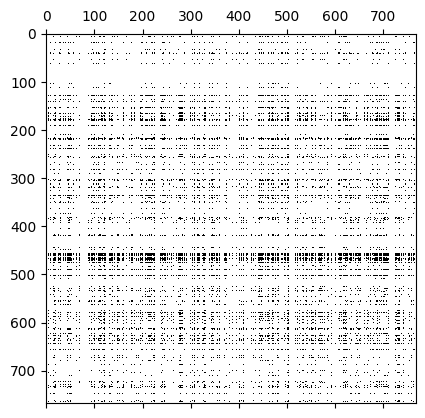

In [12]:
trainer.fit(
    model=pl_roseLora_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

In [13]:
trainer.test(pl_roseLora_model, dataloaders = test_dataloader);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Acc/test          │    0.8197101354598999     │
└───────────────────────────┴───────────────────────────┘

# Графики

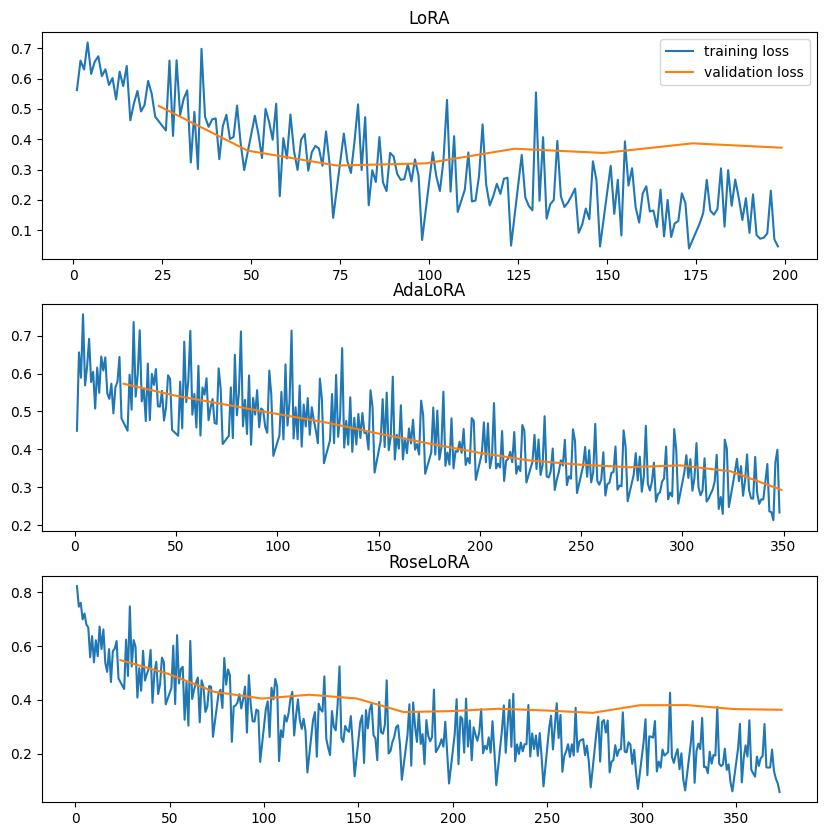

In [2]:
import matplotlib.pyplot as plt
metrics = pd.read_csv('logs/GLUE_roselora/baseline/metrics.csv')
metrics_ada = pd.read_csv('logs/GLUE_adalora/baseline/metrics.csv')
metrics_base = pd.read_csv('logs/GLUE_lora/baseline/metrics.csv')
fig, ax = plt.subplots(3,figsize = (10,10))
ax[0].plot(metrics_base['loss/train'][metrics_base['loss/train'].notna()], label = 'training loss')
ax[0].plot(metrics_base['loss/val'][metrics_base['loss/val'].notna()], label = 'validation loss')
ax[0].legend()
ax[0].set_title("LoRA")
ax[1].plot(metrics_ada['loss/train'][metrics_ada['loss/train'].notna()], label = 'training loss')
ax[1].plot(metrics_ada['loss/val'][metrics_ada['loss/val'].notna()], label = 'validation loss')
ax[1].set_title("AdaLoRA")
ax[2].plot(metrics['loss/train'][metrics['loss/train'].notna()], label = 'training loss')
ax[2].plot(metrics['loss/val'][metrics['loss/val'].notna()], label = 'validation loss')
ax[2].set_title("RoseLoRA")
plt.savefig("Plots/Loss.png")
plt.show()

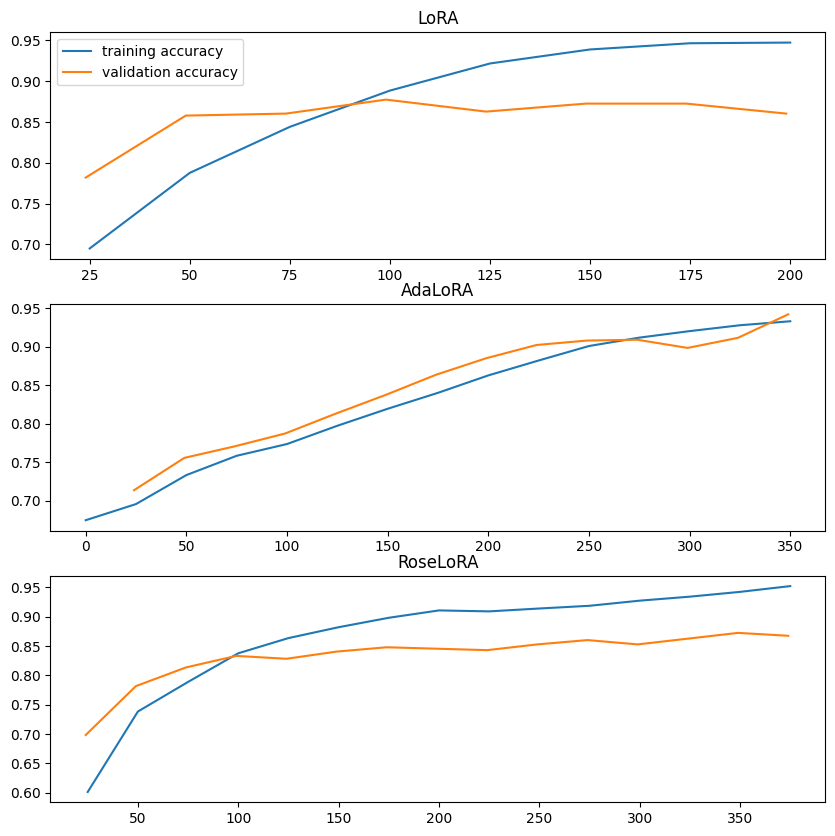

In [3]:
fig, ax = plt.subplots(3,figsize = (10,10))
ax[0].plot(metrics_base['Acc/train'][metrics_base['Acc/train'].notna()], label = 'training accuracy')
ax[0].plot(metrics_base['Acc/val'][metrics_base['Acc/val'].notna()], label = 'validation accuracy')
ax[0].legend()
ax[0].set_title("LoRA")
ax[1].plot(metrics_ada['Acc/train'][metrics_ada['Acc/train'].notna()], label = 'training accuracy')
ax[1].plot(metrics_ada['Acc/val'][metrics_ada['Acc/val'].notna()], label = 'validation accuracy')
ax[1].set_title("AdaLoRA")
ax[2].plot(metrics['Acc/train'][metrics['Acc/train'].notna()], label = 'training accuracy')
ax[2].plot(metrics['Acc/val'][metrics['Acc/val'].notna()], label = 'validation accuracy')
ax[2].set_title("RoseLoRA")
plt.savefig("Plots/Acc.png")
plt.show()

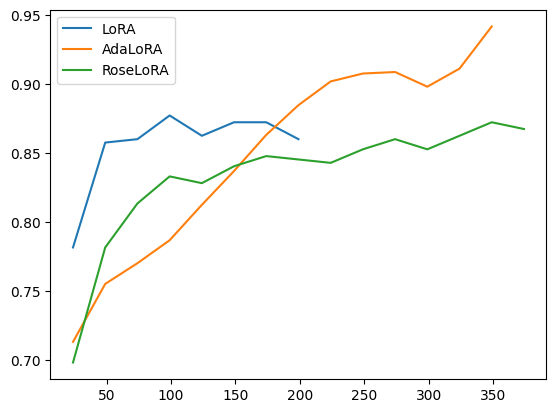

In [4]:
plt.Figure(figsize = (16,10))
plt.plot(metrics_base['Acc/val'][metrics_base['Acc/val'].notna()], label = 'LoRA')
plt.plot(metrics_ada['Acc/val'][metrics_ada['Acc/val'].notna()], label = 'AdaLoRA')
plt.plot(metrics['Acc/val'][metrics['Acc/val'].notna()], label = 'RoseLoRA')
plt.legend()
plt.savefig("Plots/Acc_comp.png")
plt.show()

In [81]:
import re
def sort_human(l):
    convert = lambda text: float(text) if text.isdigit() else text
    alphanum = lambda key: [float(c) for c in re.findall('([+-]?\d+\.?\d*)', key)]
    l.sort(key=alphanum)
    return l

In [ ]:
from PIL import Image
import glob

paths = glob.glob('Plots/it_*')
paths = sort_human(paths)
# Список для хранения кадров.
frames = []
 
for frame_path in paths:
    # Открываем изображение каждого кадра.
    frame = Image.open(frame_path)
    # Добавляем кадр в список с кадрами.
    frames.append(frame)
 
# Берем первый кадр и в него добавляем оставшееся кадры.
frames[0].save(
    'sparsity.gif',
    save_all=True,
    append_images=frames[1:],  # Срез который игнорирует первый кадр.
    optimize=True,
    duration=500,
    loop=0
)